In [26]:
#import libraries
import sys
import os
import pickle
import time
from time import sleep
import tqdm
from progressbar import progressbar
import re
import numpy as np
import pandas as pd

from alive_progress import alive_bar
from imblearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
import xgboost as xgb
from xgboost import XGBClassifier
#import lightgbm as lgbm
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.multiclass import type_of_target
from math import sqrt

import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
optuna.logging.set_verbosity(optuna.logging.WARNING)

from sklearn.utils import resample
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.feature_selection import SelectFromModel

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
import seaborn as sns

sys.path.append('/Users/bethbarlow/Documents/Nanodegree/udacity_ds_nanodegree_capstone')

from utils.helpers import plot_feature_importances

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', None) 

In [11]:
# load data
df = pd.read_csv('/Users/bethbarlow/Documents/Nanodegree/udacity_ds_nanodegree_capstone/data/data_preproc.csv')

In [12]:
df.columns
df.drop(columns = 'Unnamed: 0', inplace = True)

In [13]:
le = preprocessing.LabelEncoder()
le.fit(df.Sector)
df.Sector = le.transform(df.Sector) # encode sector
le.fit(df.Rating)
df.Rating = le.transform(df.Rating) # encode rating
le.fit(df['Rating Agency Name'])
df['Rating Agency Name'] = le.transform(df['Rating Agency Name']) # encode rating agency name

In [14]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [15]:
X.shape, y.shape

((2026, 28), (2026,))

In [16]:
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
# plot the distribution
#plt.bar(counter.keys(), counter.values())
#plt.show()

Class=0, n=398 (19.645%)
Class=4, n=670 (33.070%)
Class=1, n=94 (4.640%)
Class=3, n=490 (24.186%)
Class=2, n=302 (14.906%)
Class=5, n=72 (3.554%)


In [17]:
numerical_ix = df.iloc[:, 3:23].columns.tolist()
categorical_ix = ['Rating Agency Name', 'Sector']

encoder = OneHotEncoder(handle_unknown = 'ignore')

X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_ix]).toarray())
X_encoded.columns = encoder.get_feature_names_out(categorical_ix)
X = X.join(X_encoded)
X.drop(columns = categorical_ix, axis = 1, inplace = True)

In [19]:
# create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/5)

# scale numerical features
scaler = MinMaxScaler()
X_train[numerical_ix] = scaler.fit_transform(X_train[numerical_ix]) # check - do you scale cyclical variables?
X_test[numerical_ix] = scaler.transform(X_test[numerical_ix])

In [20]:
# create validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 1/5)

### Fit Models

In [21]:
X_train.shape, X_val.shape, X_test.shape

((1296, 42), (324, 42), (406, 42))

In [22]:
def fit_model_get_predictions(classifier, features):
    
    """
    Fits a model and gets predictions and execution times for train and test sets
    """
    start_time = time.time()
    
    trained_model = classifier.fit(X_train, y_train)
    training_execution_time = time.time() - start_time
                              
    trained_model.feature_names = features
    
    # get predictions
    train_preds = classifier.predict(X_train)
    train_classification = classification_report(y_train, train_preds)
    
    train_f1 = f1_score(y_train, train_preds, average = 'weighted')

    start_time = time.time()
    val_preds = classifier.predict(X_val)
    prediction_execution_time = time.time() - start_time
    
    val_f1 = f1_score(y_val, val_preds, average = 'weighted')
    
    # get model and predictions dictionary
    model_and_predictions_dictionary = {
        
        'classifier': classifier,
        'train_f1': train_f1,
        'val_f1': val_f1,
        'training_execution_time': np.round(training_execution_time, 0),
        'prediction_execution_time': np.round(prediction_execution_time, 0)
        
    }
    
    return model_and_predictions_dictionary

In [23]:
features = X.columns.tolist()

In [24]:
# multinomial logistic regression
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 1000)

lr_results = fit_model_get_predictions(lr, features)
lr_results

{'classifier': LogisticRegression(max_iter=1000, multi_class='multinomial'),
 'train_f1': 0.3860024038682445,
 'val_f1': 0.3731148276656803,
 'training_execution_time': 0.0,
 'prediction_execution_time': 0.0}

In [30]:
# Random forest
rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
rf_results = fit_model_get_predictions(rf, features)
rf_results

{'classifier': RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42),
 'train_f1': 0.9907456818806734,
 'val_f1': 0.4908545381786499,
 'training_execution_time': 0.0,
 'prediction_execution_time': 0.0}

In [31]:
# KNN
knn = KNeighborsClassifier()
knn_results = fit_model_get_predictions(knn, features)
knn_results

{'classifier': KNeighborsClassifier(),
 'train_f1': 0.5242042809817,
 'val_f1': 0.3847901087590057,
 'training_execution_time': 0.0,
 'prediction_execution_time': 0.0}

In [32]:
# naive bayes
gnb = GaussianNB()

gnb_results = fit_model_get_predictions(gnb, features)
gnb_results

{'classifier': GaussianNB(),
 'train_f1': 0.13448809908475834,
 'val_f1': 0.09599853877084695,
 'training_execution_time': 0.0,
 'prediction_execution_time': 0.0}

In [33]:
# XGBoost 
xgb = XGBClassifier()
xgb_results = fit_model_get_predictions(xgb, features)
xgb_results

{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               objective='multi:softprob', predictor=None, ...),
 'train_f1': 1.0,
 'val_f1': 0.5543219885379586,
 'training_execution_time': 3.0,
 'prediction_execution_time': 0.0}

In [34]:
val_f1_list = [lr_results['val_f1'], rf_results['val_f1'], knn_results['val_f1'], gnb_results['val_f1'], xgb_results['val_f1']]

model_list = ['Multinomial Logistic Regression', 'Random Forest','KNN', 'Naive Bayes', 'XGBoost']

df_f1 = pd.DataFrame({'Model': model_list, 'F1 Score': val_f1_list})

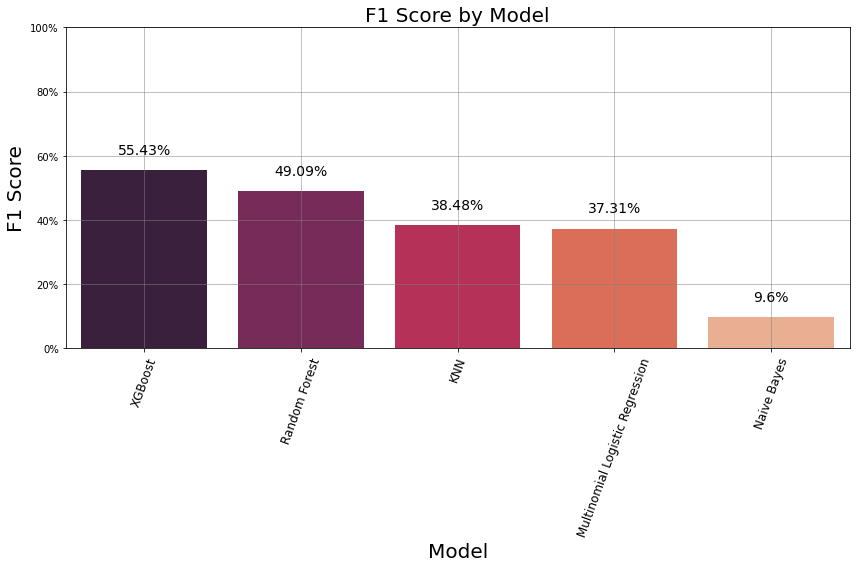

In [35]:
order = list(df_f1.sort_values('F1 Score', ascending=False).Model)
df_f1 = df_f1.sort_values('F1 Score', ascending=False).reset_index().drop(['index'], axis=1)

plt.figure(figsize=(12,8))
# make barplot and sort bars
x = sns.barplot(x='Model', y="F1 Score", data=df_f1, order = order, palette="rocket")
plt.xlabel("Model", fontsize=20)
plt.ylabel("F1 Score", fontsize=20)
plt.title("F1 Score by Model", fontsize=20)
plt.grid(linestyle='-', linewidth='0.5', color='grey')
plt.xticks(rotation=70, fontsize=12)
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

for i in range(len(model_list)):
    plt.text(x = i, y = df_f1.loc[i, 'F1 Score'] + 0.05, s = str(round((df_f1.loc[i, 'F1 Score'])*100, 2))+'%', 
             fontsize = 14, color='black',horizontalalignment='center')

plt.tight_layout()

### Hyperparameter tuning on validation set

In [36]:
val_df = pd.concat([y_val, X_val], axis = 1)

In [37]:
%time

cv_results = {}
confusion_matrix_plots = []
scores = {"AUC" : []}
models = {}
seed = 1
sampler_type = "RandomUnderSampler"

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


In [ ]:
# define objective function for optuna to maximize

def objective(trial):
    
    """
    Takes a trial object as input and returns score
    """

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500, 50),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'eval_metric': 'auc',
    }
    
    clf = XGBClassifier(**params)
        
    start_time = time.time()
    clf.fit(X_train_res, y_train_res)
    training_execution_time = time.time() - start_time
    
    preds = np.rint(clf.predict(X_val))
    val_df['predictions'] = preds
        
    f1 = metrics.f1_score(y_val, preds, average = 'micro')
    
    return f1

In [ ]:
start_time = time.time()
sampler_types = ["RandomUnderSampler", "RandomOverSampler", "SMOTE"]
optim_results = {}
best_params = {}
sampling_folds = 3
n_trials = 30
        
# Loop over sampling types:
for sampler_type in sampler_types:

    # Optimise parameters for all three samplers
    study = optuna.create_study(direction = 'maximize')

    # Get a new sample after n trials are completed and repeat for n folds
    for i in range(sampling_folds):

        # Define sampler
        sampler = eval(sampler_type)()

        # Get a new sample
        X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)

        study.optimize(objective, n_trials = n_trials)
        
        best_params = study.best_params
        best_score = study.best_value
        print(f"Sampler: {sampler_type}\n")
        print(f"Best score: {best_score}\n")
        print(f"Optimized parameters: {best_params}\n")

    print("Number of finished trials:", len(study.trials))

    trial = study.best_trial
    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))

    best_params[sampler_type] = trial.params

    optim_results[sampler_type] = study

#     plot_optimization_history(study).show()
#     plot_contour(study).show()
#     plot_param_importances(study).show()

optimisation_time = time.time() - start_time


In [ ]:
tuning_summary = pd.DataFrame(columns = 
                               ["Sampler",
                               "Trial",
                               "f1-score",
                               "Parameters"])

# One study for each sampler, n trials within each study. Take best trial.
for sampler, study in optim_results.items():
    
    tuning_summary.loc[len(tuning_summary.index)] = [
        sampler,
        int(study.best_trial.number),
        study.best_trial.values[0],
        study.best_trial.params,
    ]

    tuning_summary['Trial'] = tuning_summary['Trial'].astype(int)
                            
time_taken = optimisation_time/60
tuning_summary = tuning_summary.round(4)            

In [ ]:
tuning_summary

In [ ]:
### Re-train with tuned hyperparameters

# best model is XGBoost
%time

# Combine train and validation sets to train model on full training set
X_train = pd.concat([X_train, X_val], axis = 0)
y_train = pd.concat([y_train, y_val], axis = 0)

In [ ]:
X_train.shape, y_train.shape

In [ ]:
scores = {"f1" : []}
models, model_metrics = {}, {}
seed = 1
n_splits = 3
sampling_strategies = ["RandomUnderSampler", "RandomOverSampler", "SMOTE"]
tuned_params = dict(zip(tuning_summary.Sampler, tuning_summary.Parameters))

for strategy in sampling_strategies:
        
        model_name = "{} + XGBoost".format(strategy)
            
        eval_result = {}
            
        clf = XGBClassifier(**tuned_params[strategy])
            
        clf.fit(X_train, y_train)
        
        predictions = clf.predict(X_test)
        
        f1 = f1_score(y_test, predictions, average = 'micro')
        
        models[model_name] = clf
        model_metrics[model_name] = f1

In [ ]:
# Write results to log

for idx, model in models.items():
    
    print(idx)
    y_pred = model.predict(X_test)
    report_dict = metrics.classification_report(y_test, y_pred, output_dict = True)

    display(pd.DataFrame(report_dict).T.round(decimals = 2))

    
#     # Create a dictionary of desired metrics to write to a dataframe
#     df_list.append(
#         {
#             "Model" : idx,
#             "Precision" : report_dict.get("precision"),
#             "Recall" : report_dict.get("recall"),
#             "Accuracy" : report_dict.get("accuracy")
            
#         }
#     )
    
# model_results = pd.DataFrame(df_list)
# model_results

In [ ]:
# Feature Importances
for idx, model in models.items():
    plot_feature_importances(model, idx, features)